# ==== INTERACTIVE CLUSTERING : RENTABILITY STUDY ====
> ### Stage 1 : Evaluate rentability of one more iteration.

------------------------------
## READ-ME BEFORE RUNNING

### Quick Description

This notebook is **aimed at compute rentability of performaing one more iteration of interactive clustering**.
- Computations are based on previous experiments (cf. efficience study) exported in `./previous` folder.
- Environments results are stored in their `.JSON` files in the `/experiments` folder.

Then, **go to the notebook `2_Plot_some_figures.ipynb` to plot several figures according to these computations**.

### Description each steps

The several computations are :
- `annotation_agreement_score`: Compute the proportion of annotations that is similar to previous clustering results ("MUST_LINK" when same cluster, "CANNOT_LINK" when different clusters). If agreement is low (near to `0.0`), then constraints annotated will considerably fix clustering in next iteration. Otherwise, clustering is stable.
- `clustering_similarity_moving_average`: Compute v-measure between two clustering (to estimate local similarity) then use MACD (_moving average convergence divergence_) method to predict convergence.

------------------------------
## 1. IMPORT PYTHON DEPENDENCIES

In [1]:
from typing import Any, Dict, List, Optional, Tuple
import os
import json

In [2]:
import warnings
warnings.filterwarnings("ignore")

------------------------------
## 2. LOAD EXPERIMENTS TO STUDY

Find all implementations to analyze and associated experiments.

In [3]:
# List of run tasks to parallelize.
LIST_OF_TASKS: List[Dict[str, str]] = [
    {
        "implementation": implementation,  # Environment of experiment.
        "experiments": [
            exp_path
            for exp_path in os.listdir("../previous/"+implementation)
            if ".json" in exp_path
        ]
    }
    for implementation in os.listdir("../previous")
    if (
        os.path.isdir("../previous/" + implementation)
        and implementation in [
            "bank_cards_v1_-_simple_prep_-_tfidf_-_closest-50_-_hier_avg-10c",  # best to reach 90% of v-measure (cf. efficiency study)
            "bank_cards_v1_-_lemma_prep_-_tfidf_-_closest-50_-_kmeans_COP-10c",  # best to reach 100% of v-measure (cf. efficiency study)
            "bank_cards_v1_-_lemma_prep_-_tfidf_-_in_same-50_-_kmeans_COP-10c",  # best to reach annotation completeness (cf. efficiency study)
            "bank_cards_v1_-_simple_prep_-_tfidf_-_closest-50_-_kmeans_COP-10c",  # choice of author (cf. cost study)
            #"bank_cards_v1_-_simple_prep_-_tfidf",  # Mean.
            #"bank_cards_v1",  # Mean.
        ]
    )
]
print("There are", "`" + str(len(LIST_OF_TASKS)) + "`", "implementations to analyze.")

There are `4` implementations to analyze.


Create one folder per implementation to analyze.

In [4]:
for task in LIST_OF_TASKS:
    
    # If folder exists: continue.
    if os.path.isdir("../experiments/" + task["implementation"]):
        continue
    
    # Create folder for analyses.
    os.mkdir("../experiments/" + task["implementation"])
    
    # Copy data.
    for experiment in task["experiments"]:
        with open("../previous/" + task["implementation"] + "/" + experiment, "r") as file_previous_results_r:
            previous_results = json.load(file_previous_results_r)
        with open("../experiments/" + task["implementation"] + "/previous_results___" + experiment, "w") as file_previous_results_w:
            json.dump(
                previous_results,
                file_previous_results_w
            )

------------------------------
## 3. START ANALYSES

----------
### 3.1. Analyze annotation agreement score between annotator and previous clustering.

Define annotation agreement score.

In [5]:
from annotation_agreement_score import compute_annotation_agreement_score, display_annotation_agreement_score

Compute all annotation agreement scores.

In [6]:
# For each implementation.
for task in LIST_OF_TASKS:
    print("IMPLEMENTATION:", task["implementation"])
    
    # For each experiments.
    for experiment in task["experiments"]:
        print("    ", "experiment:", experiment)
    
        # If folder exists: continue.
        if os.path.exists("../experiments/" + task["implementation"] + "/annotation_agreement_score___" + experiment):
            continue
        
        # Load data
        with open("../experiments/" + task["implementation"] + "/previous_results___" + experiment, "r") as file_experiment_data_r:
            experiment_data: Dict[str, Any] = json.load(file_experiment_data_r)
        dict_of_constraints_annotations: Dict[str, List[Tuple[str, str, str]]] = experiment_data["dict_of_constraints_annotations"]
        dict_of_clustering_results: Dict[str, Dict[str, str]] = experiment_data["dict_of_clustering_results"]
            
        # Compute annotation agreement score for each iteration.
        annotation_agreement_score_evolution: Dict[str, float] = {}
        previous_iteration: Optional[str] = None
        for iteration in dict_of_constraints_annotations.keys():
            # Compute annotation agreement score. No annotation in iteration "0000", so no agreement score to compure.
            if iteration != "0000":
                annotation_agreement_score_evolution[iteration] = compute_annotation_agreement_score(
                    clustering=dict_of_clustering_results[previous_iteration],
                    annotations=dict_of_constraints_annotations[iteration],
                )
            # Update temporary variables.
            previous_iteration = iteration
        
        # Store results.
        with open("../experiments/" + task["implementation"] + "/annotation_agreement_score___" + experiment, "w") as file_annotation_agreement_score_w:
            json.dump(
                annotation_agreement_score_evolution,
                file_annotation_agreement_score_w,
            )

IMPLEMENTATION: bank_cards_v1_-_lemma_prep_-_tfidf_-_closest-50_-_kmeans_COP-10c
     experiment: 0001.json
     experiment: 0002.json
     experiment: 0003.json
     experiment: 0004.json
     experiment: 0005.json
IMPLEMENTATION: bank_cards_v1_-_lemma_prep_-_tfidf_-_in_same-50_-_kmeans_COP-10c
     experiment: 0001.json
     experiment: 0002.json
     experiment: 0003.json
     experiment: 0004.json
     experiment: 0005.json
IMPLEMENTATION: bank_cards_v1_-_simple_prep_-_tfidf_-_closest-50_-_hier_avg-10c
     experiment: 0001.json
     experiment: 0002.json
     experiment: 0003.json
     experiment: 0004.json
     experiment: 0005.json
IMPLEMENTATION: bank_cards_v1_-_simple_prep_-_tfidf_-_closest-50_-_kmeans_COP-10c
     experiment: 0001.json
     experiment: 0002.json
     experiment: 0003.json
     experiment: 0004.json
     experiment: 0005.json


Display annotation agreement score evolution in a graph.

In [7]:
config_annotation_agreement_score_score = {
    "bank_cards_v1_-_simple_prep_-_tfidf_-_closest-50_-_hier_avg-10c": {
        "plot_label": "Accord annotations/clustering moyen des tentatives\nayant le meilleur paramétrage moyen pour atteindre\nune annotation partielle (90% de v-measure).",
        "plot_color": "green",
        "graph_filename": "etude-rentabilite-accord-annotation-clustering-annotation-partielle.png",
    },  # best to reach 90% of v-measure (cf. efficiency study)
    "bank_cards_v1_-_lemma_prep_-_tfidf_-_closest-50_-_kmeans_COP-10c": {
        "plot_label": "Accord annotations/clustering moyen des tentatives\nayant le meilleur paramétrage moyen pour atteindre\nune annotation suffisante (100% de v-measure).",
        "plot_color": "blue",
        "graph_filename": "etude-rentabilite-accord-annotation-clustering-annotation-suffisante.png",
    },  # best to reach 100% of v-measure (cf. efficiency study)
    "bank_cards_v1_-_lemma_prep_-_tfidf_-_in_same-50_-_kmeans_COP-10c": {
        "plot_label": "Accord annotations/clustering moyen des tentatives\nayant le meilleur paramétrage moyen pour atteindre\nune annotation exhaustive (toutes les contraintes).",
        "plot_color": "red",
        "graph_filename": "etude-rentabilite-accord-annotation-clustering-annotation-exhaustive.png",
    },  # best to reach annotation completeness (cf. efficiency study)
    "bank_cards_v1_-_simple_prep_-_tfidf_-_closest-50_-_kmeans_COP-10c": {
        "plot_label": "Accord annotations/clustering moyen des tentatives\nayant notre paramétrage favori pour atteindre\n90% de v-measure avec un coût global minimal.",
        "plot_color": "gold",
        "graph_filename": "etude-rentabilite-accord-annotation-clustering-annotation-retenue.png",
    },  # choice of author (cf. cost study)
}

IMPLEMENTATION: bank_cards_v1_-_lemma_prep_-_tfidf_-_closest-50_-_kmeans_COP-10c 
    ( etude-rentabilite-accord-annotation-clustering-annotation-suffisante.png )
IMPLEMENTATION: bank_cards_v1_-_lemma_prep_-_tfidf_-_in_same-50_-_kmeans_COP-10c 
    ( etude-rentabilite-accord-annotation-clustering-annotation-exhaustive.png )
IMPLEMENTATION: bank_cards_v1_-_simple_prep_-_tfidf_-_closest-50_-_hier_avg-10c 
    ( etude-rentabilite-accord-annotation-clustering-annotation-partielle.png )
IMPLEMENTATION: bank_cards_v1_-_simple_prep_-_tfidf_-_closest-50_-_kmeans_COP-10c 
    ( etude-rentabilite-accord-annotation-clustering-annotation-retenue.png )


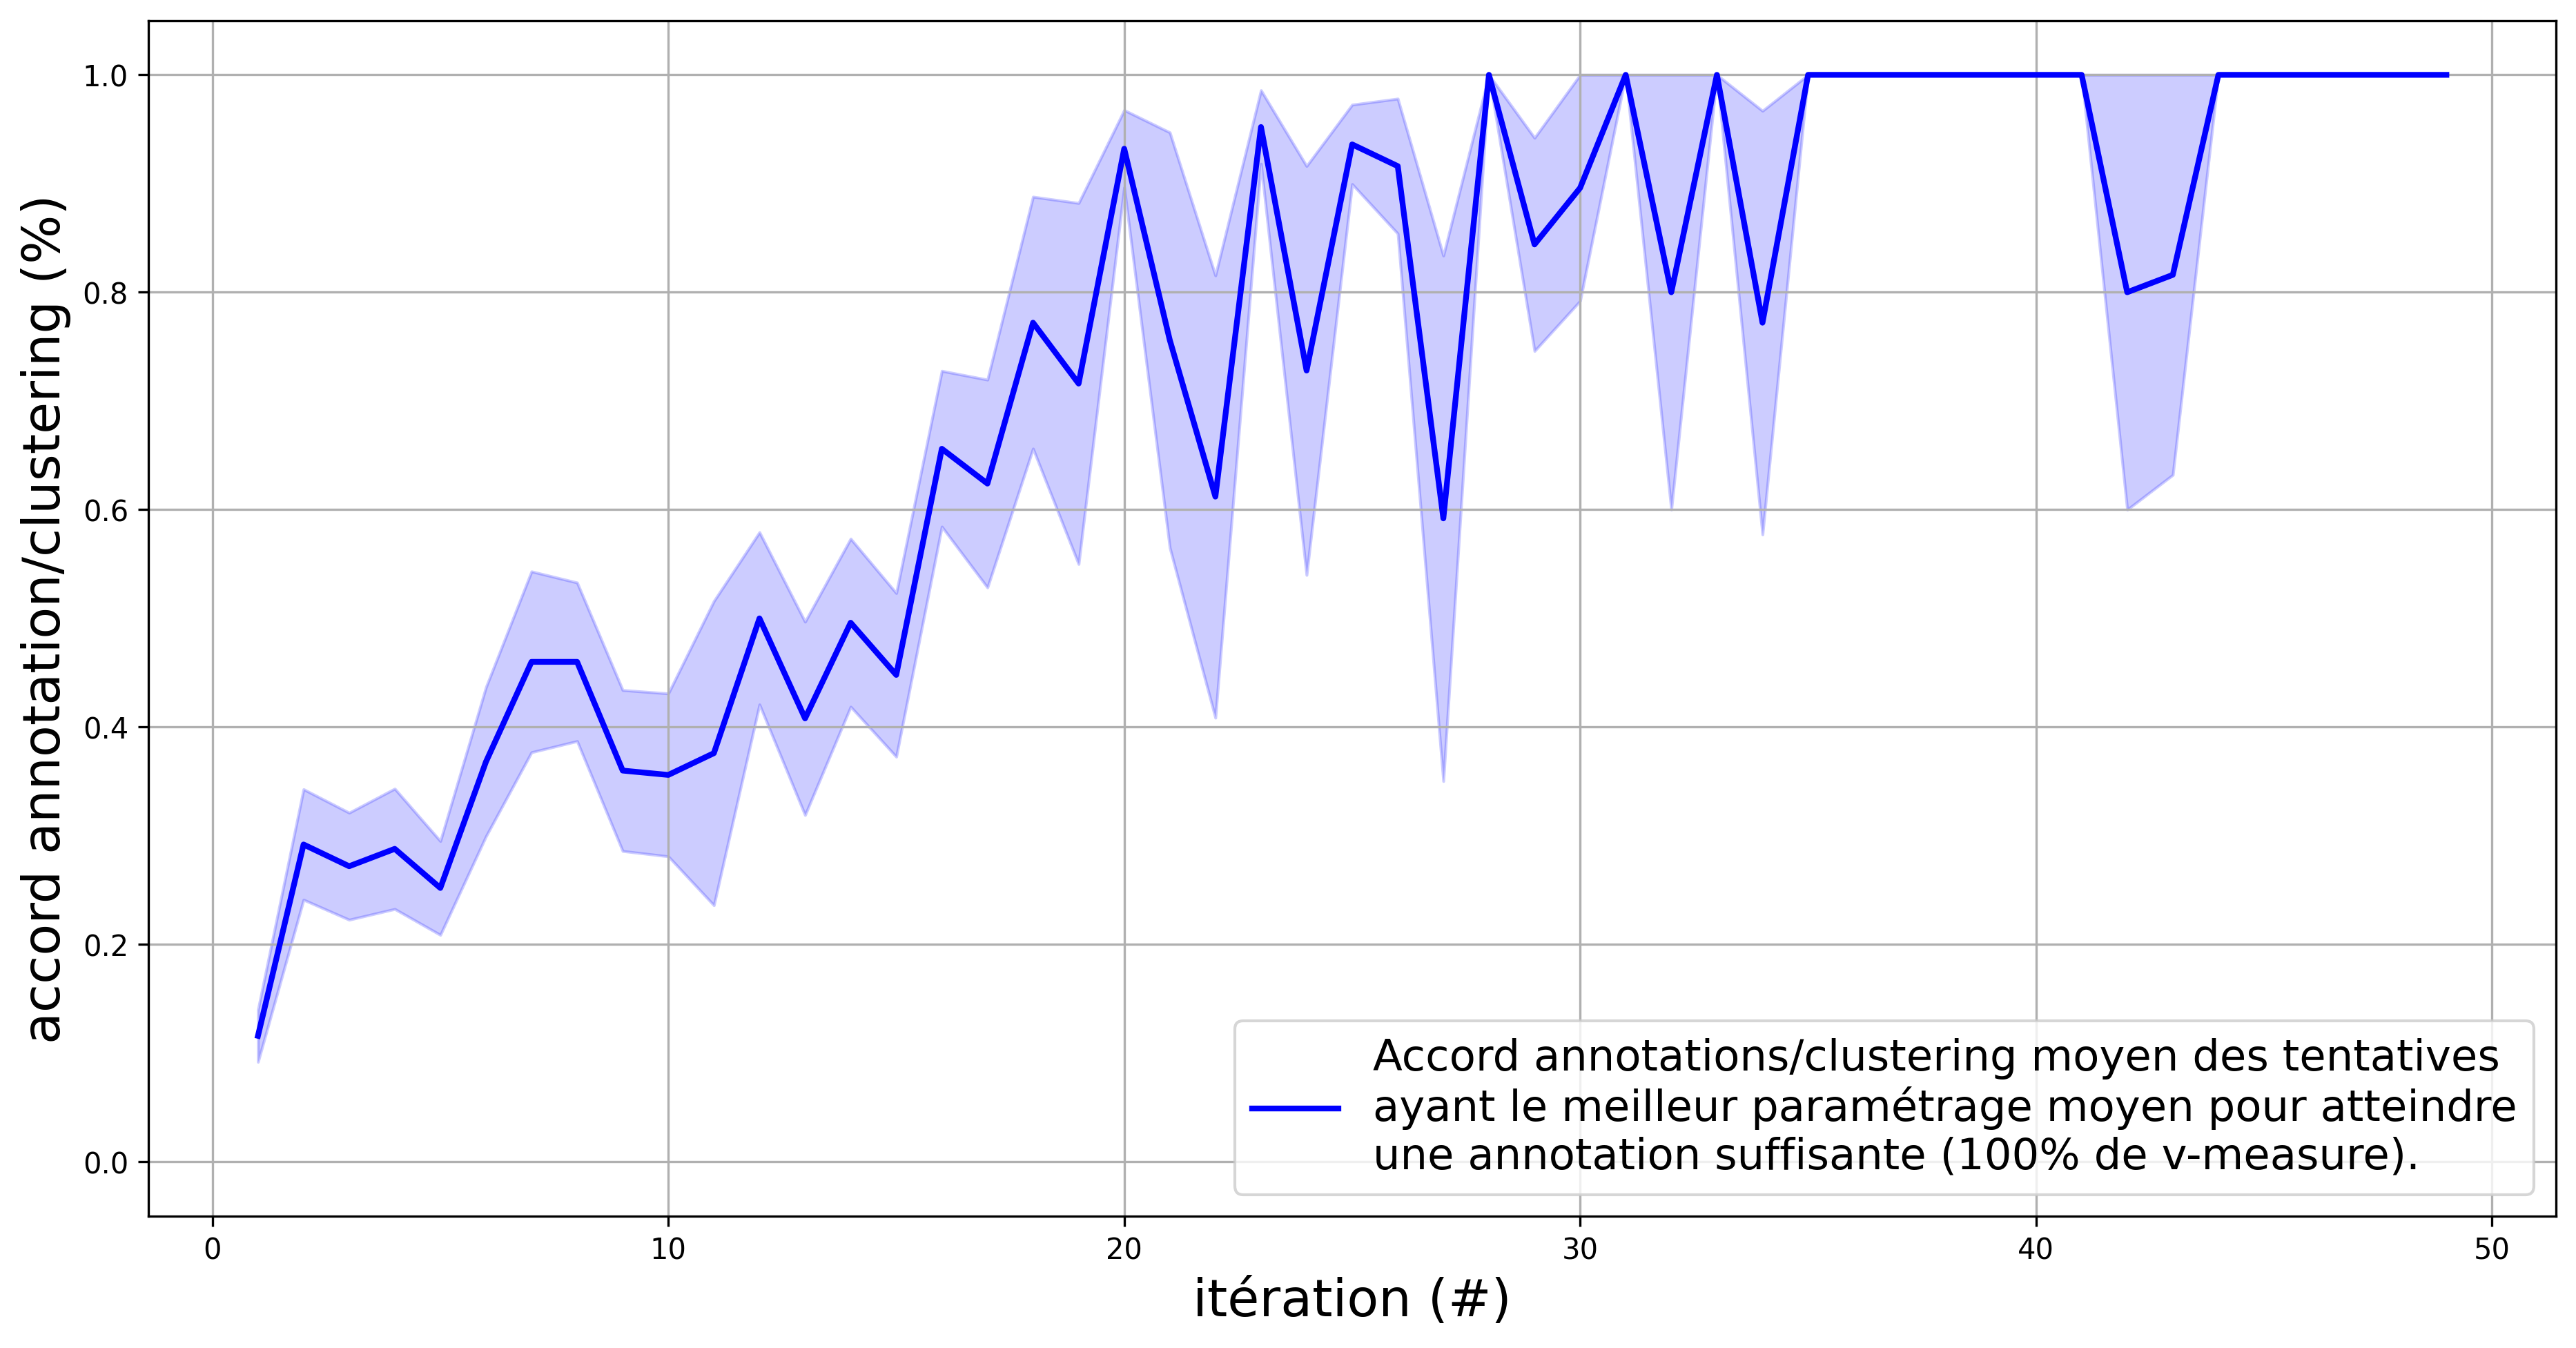

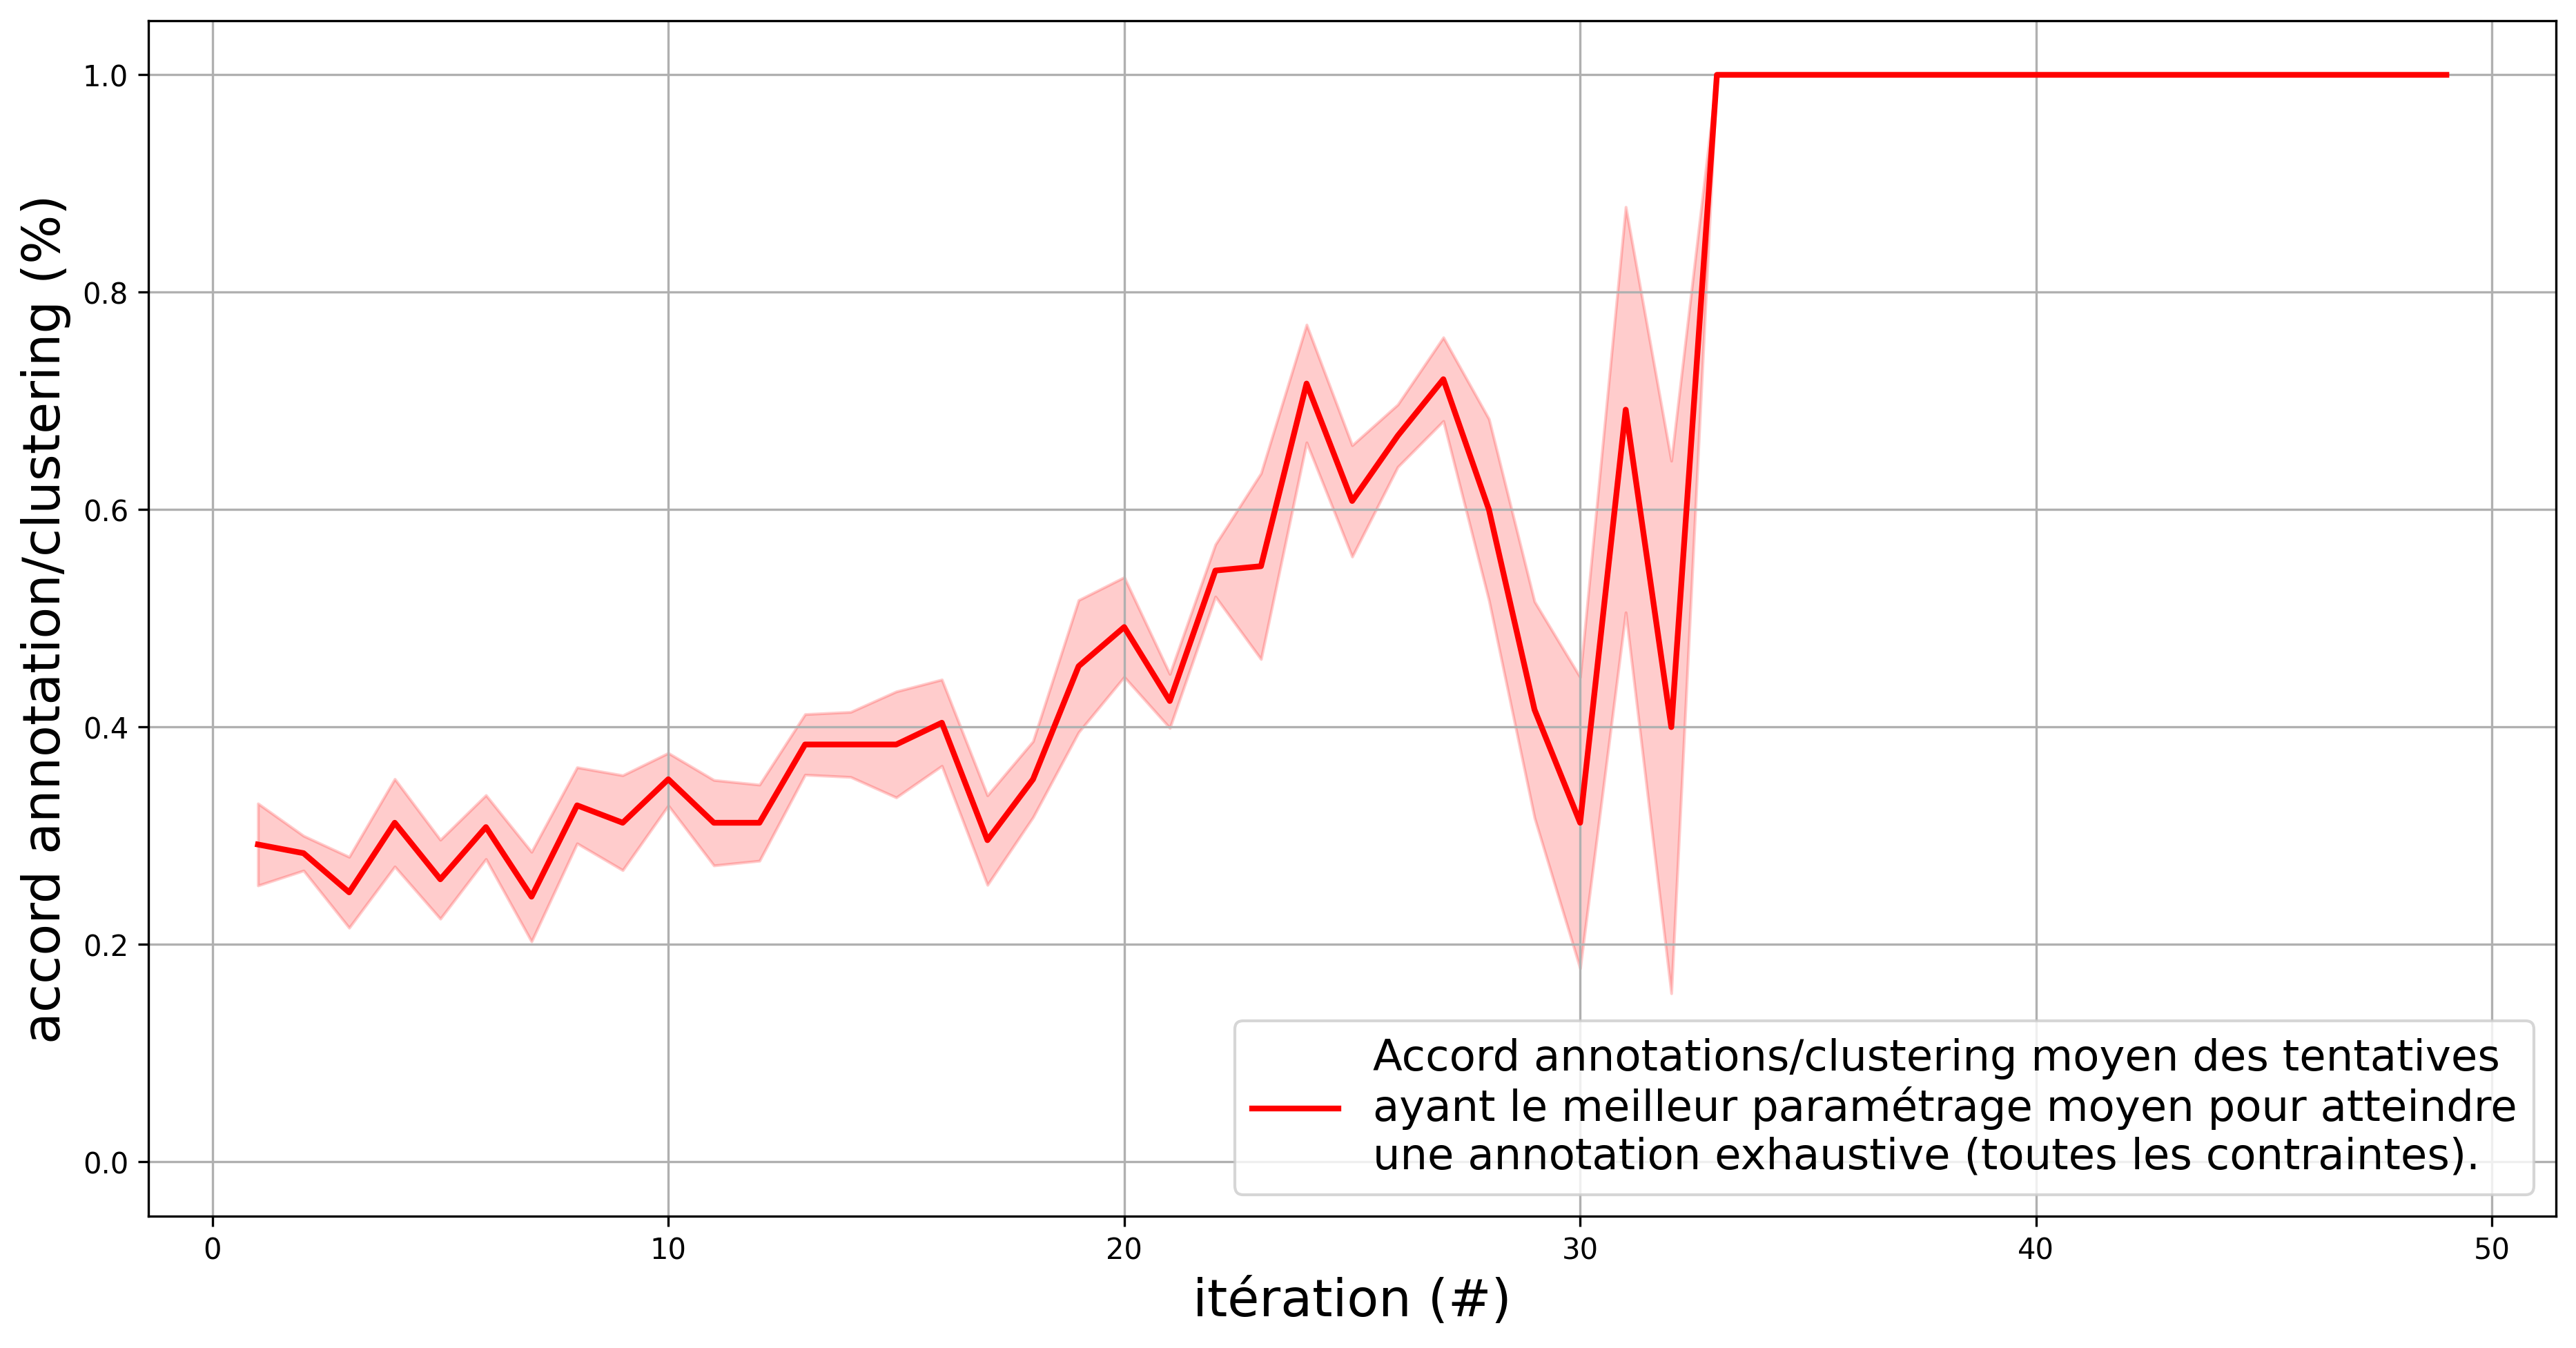

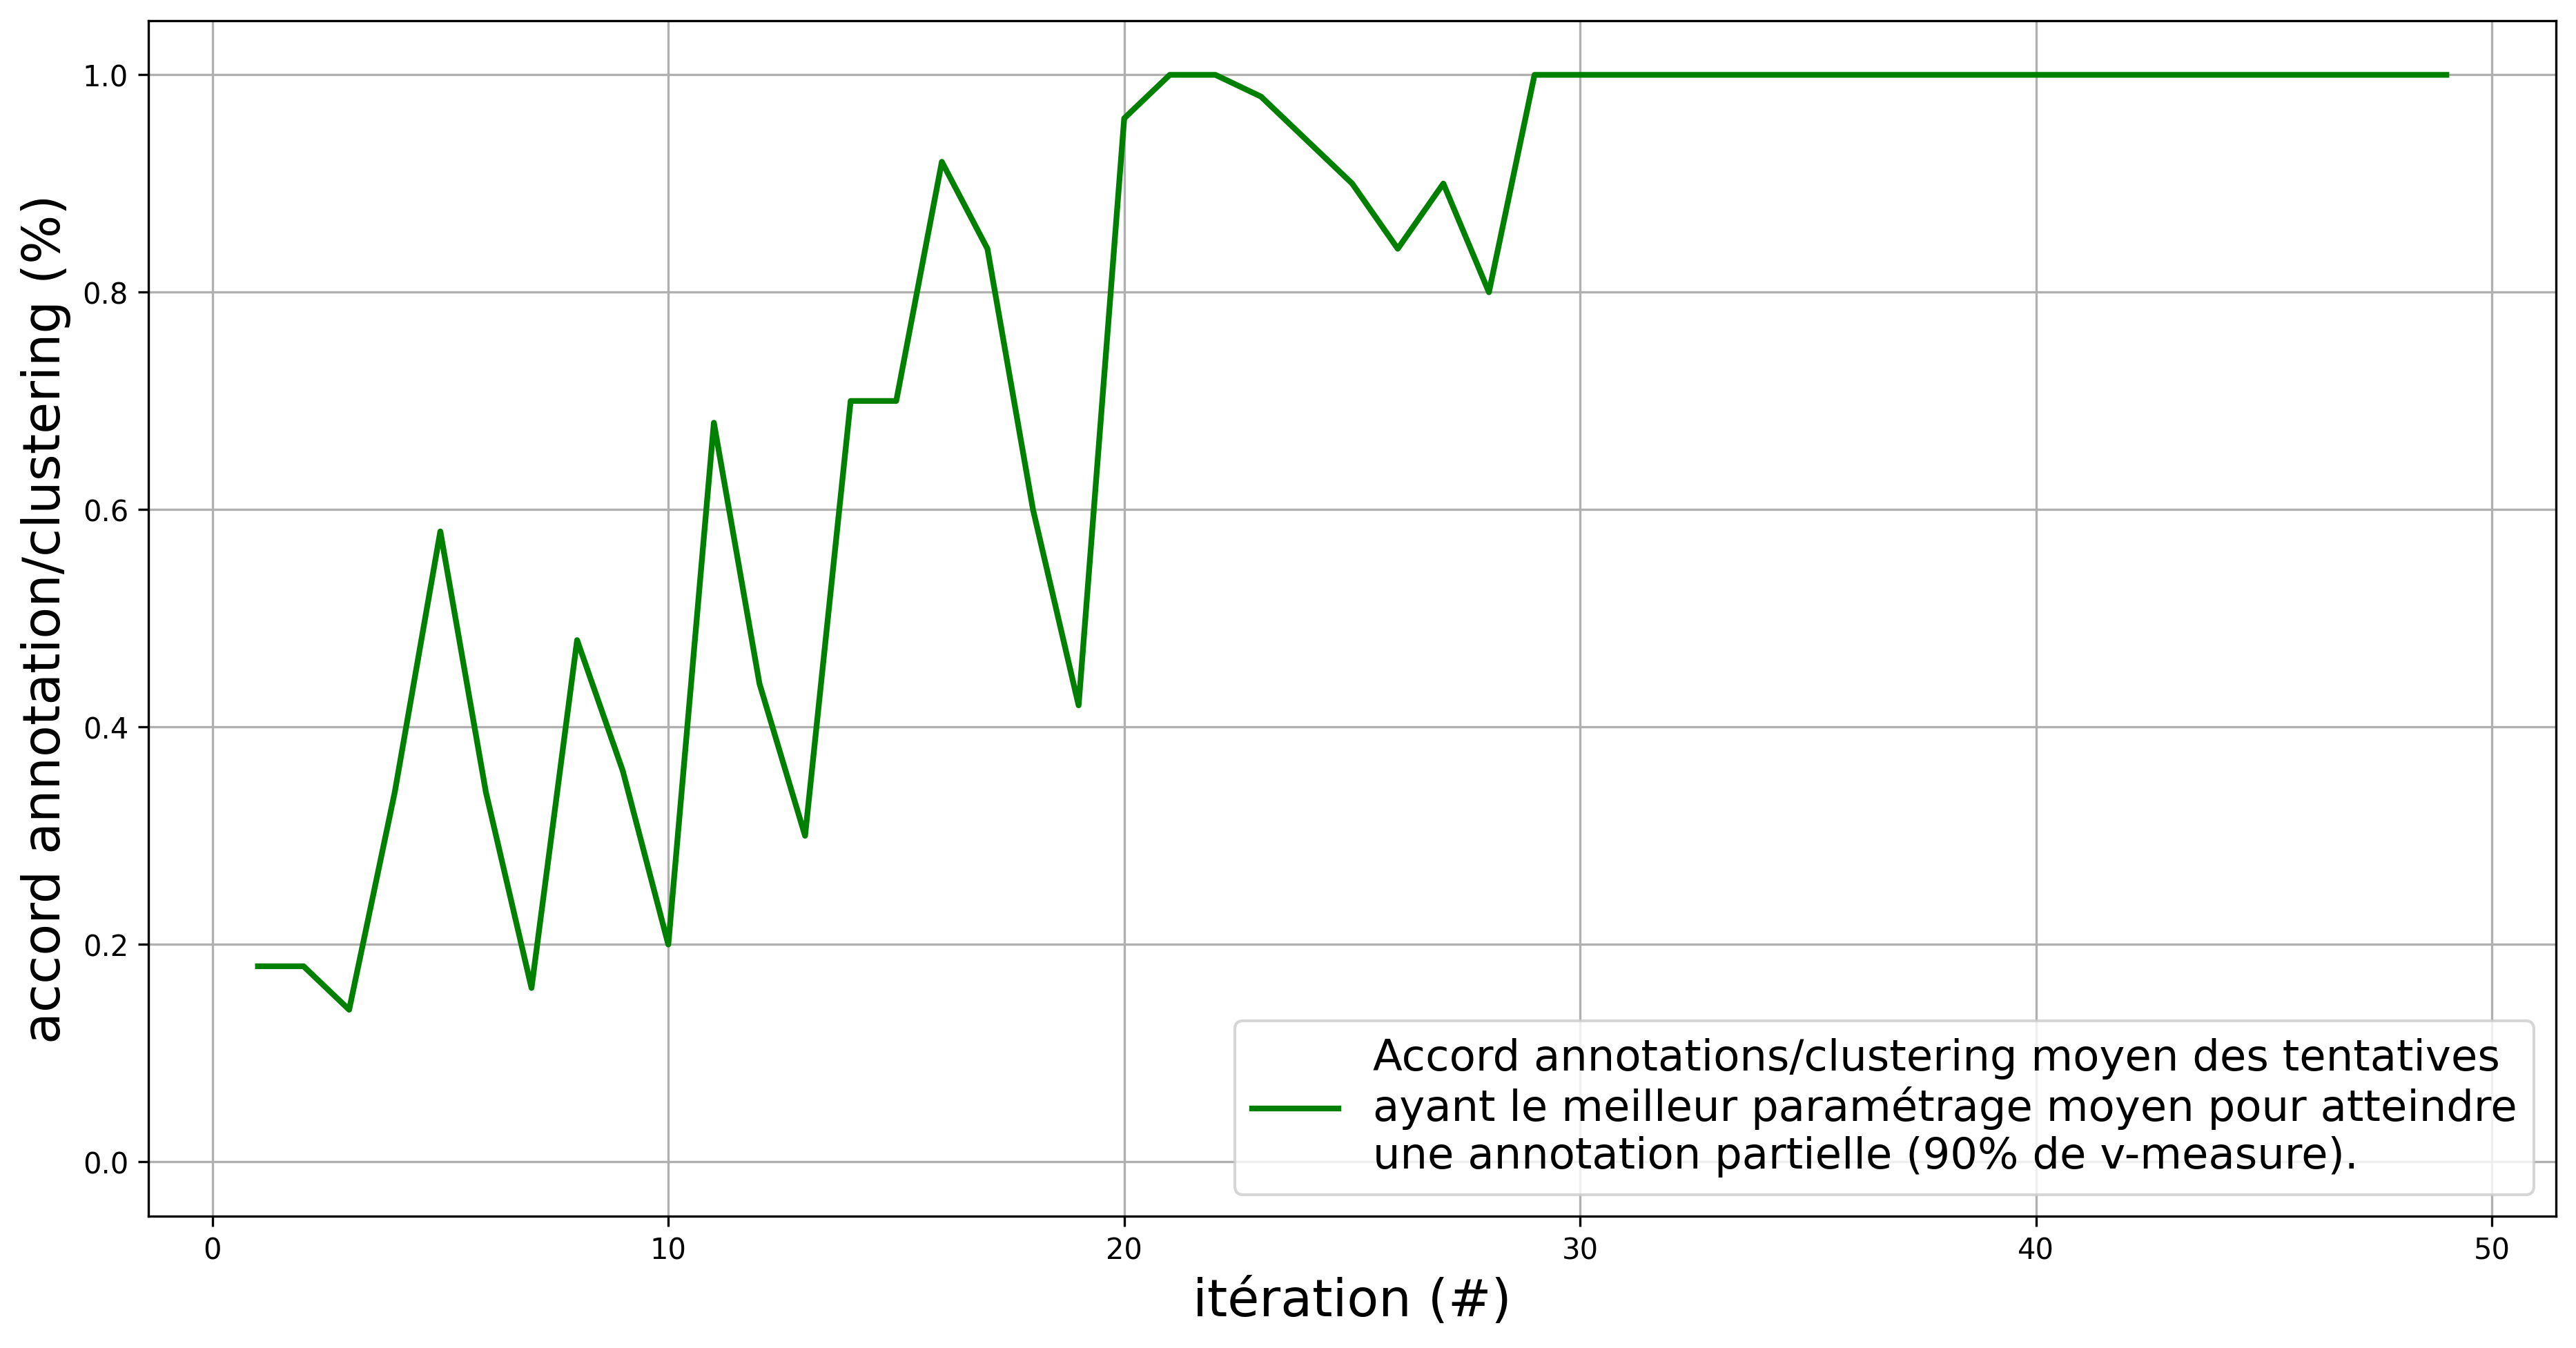

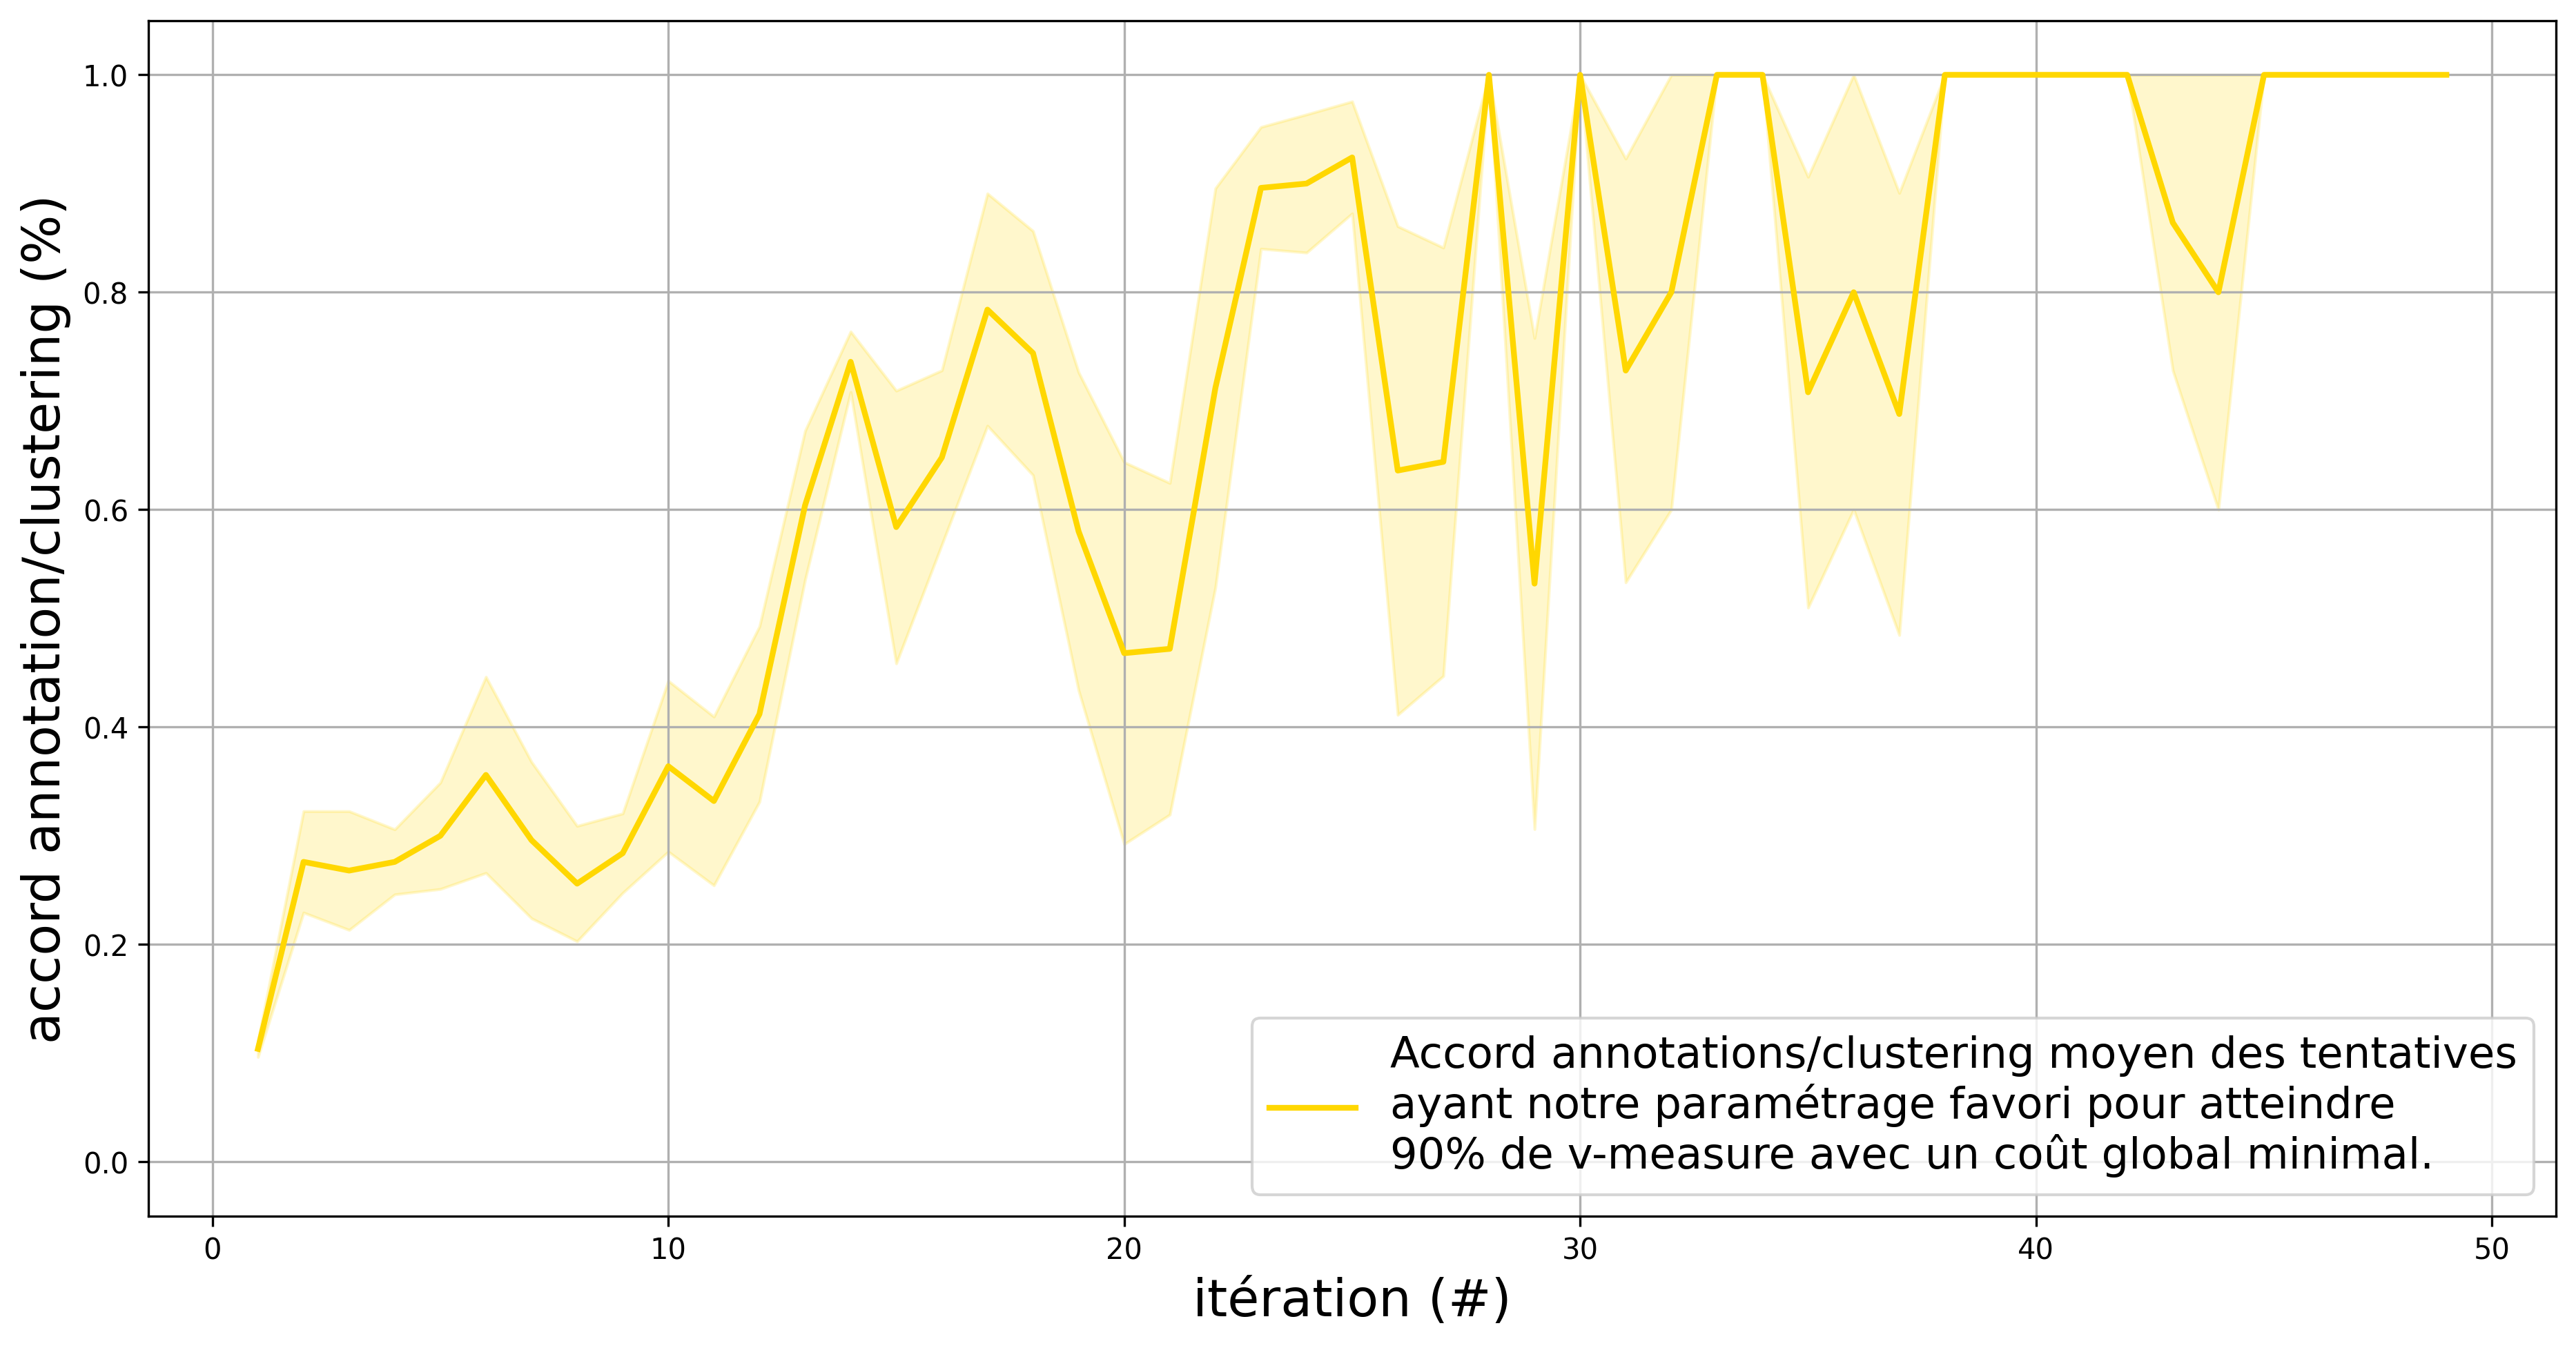

In [8]:
# For each implementation.
for task in LIST_OF_TASKS:
    print("IMPLEMENTATION:", task["implementation"], "\n    (", config_annotation_agreement_score_score[task["implementation"]]["graph_filename"], ")")
    display_annotation_agreement_score(
        implementation=task["implementation"],
        list_of_experiments=task["experiments"],
        list_of_iterations=[str(i).zfill(4) for i in range(1, 50)],
        plot_label=config_annotation_agreement_score_score[task["implementation"]]["plot_label"],
        plot_color=config_annotation_agreement_score_score[task["implementation"]]["plot_color"],
        graph_filename=config_annotation_agreement_score_score[task["implementation"]]["graph_filename"],
    )

----------
### 3.2. Analyze clustering similarity moving average.

Load Python dependencies.

In [13]:
from clustering_similarity_moving_average import compute_clustering_similarity_moving_average

Compute clustering similarity and moving average.

In [43]:
# For each implementation.
for task in LIST_OF_TASKS:
    print("IMPLEMENTATION:", task["implementation"])
    
    # For each experiments.
    for experiment in task["experiments"]:
        print("    ", "experiment:", experiment)
    
        # If folder exists: continue.
        #if os.path.exists("../experiments/" + task["implementation"] + "/clustering_similarity_moving_average___" + experiment):
        #    continue
        
        # Load data.
        with open("../experiments/" + task["implementation"] + "/previous_results___" + experiment, "r") as file_experiment_data_r:
            experiment_data: Dict[str, Any] = json.load(file_experiment_data_r)
        dict_of_clustering_results: Dict[str, Dict[str, str]] = experiment_data["dict_of_clustering_results"]
        dict_of_clustering_results: Dict[str, Dict[str, str]] = experiment_data["dict_of_clustering_results"]
            
        # Compute clustering similarity moving average.
        clustering_similarity_moving_average_evolution: Dict[str, Dict[str, float]] = compute_clustering_similarity_moving_average(
            dict_of_clustering_results=dict_of_clustering_results,
            short_average=2,
            long_average=8,
        )
        
        # Store results.
        with open("../experiments/" + task["implementation"] + "/clustering_similarity_moving_average___" + experiment, "w") as file_clustering_similarity_moving_average_w:
            json.dump(
                clustering_similarity_moving_average_evolution,
                file_clustering_similarity_moving_average_w,
            )

IMPLEMENTATION: bank_cards_v1_-_lemma_prep_-_tfidf_-_closest-50_-_kmeans_COP-10c
     experiment: 0001.json
     experiment: 0002.json
     experiment: 0003.json
     experiment: 0004.json
     experiment: 0005.json
IMPLEMENTATION: bank_cards_v1_-_lemma_prep_-_tfidf_-_in_same-50_-_kmeans_COP-10c
     experiment: 0001.json
     experiment: 0002.json
     experiment: 0003.json
     experiment: 0004.json
     experiment: 0005.json
IMPLEMENTATION: bank_cards_v1_-_simple_prep_-_tfidf_-_closest-50_-_hier_avg-10c
     experiment: 0001.json
     experiment: 0002.json
     experiment: 0003.json
     experiment: 0004.json
     experiment: 0005.json
IMPLEMENTATION: bank_cards_v1_-_simple_prep_-_tfidf_-_closest-50_-_kmeans_COP-10c
     experiment: 0001.json
     experiment: 0002.json
     experiment: 0003.json
     experiment: 0004.json
     experiment: 0005.json


Display clustering similarity moving average in a graph.

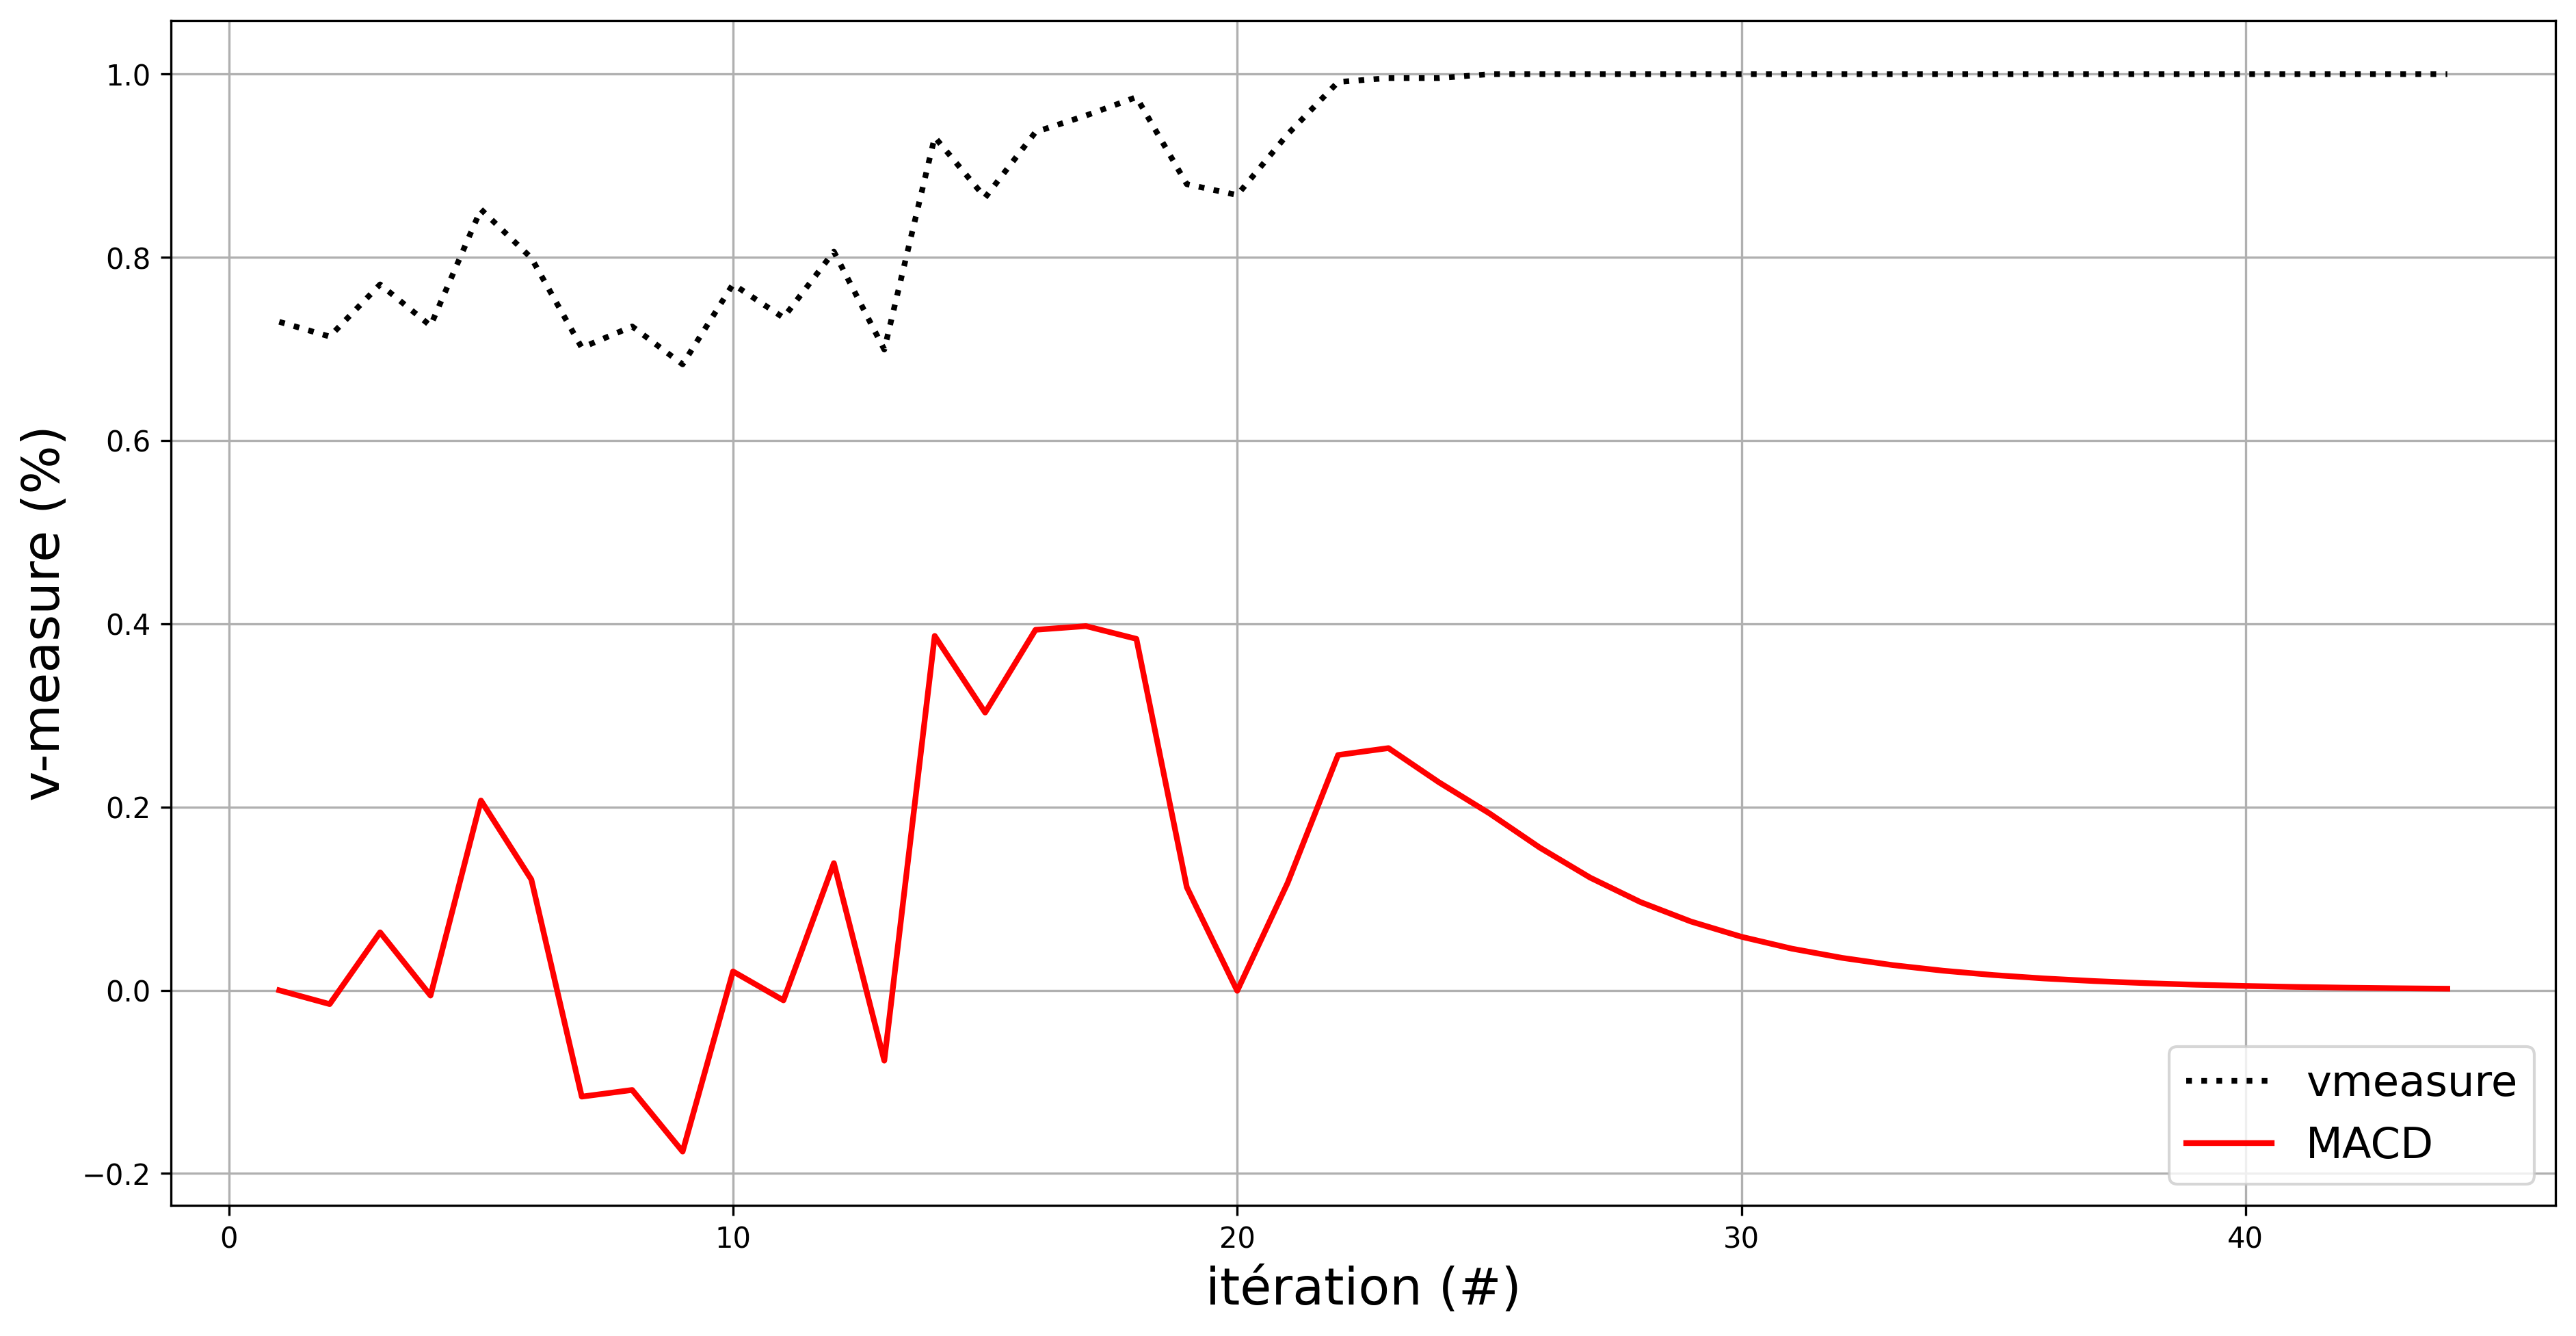

In [44]:
from matplotlib import pyplot as plt
from matplotlib.figure import Figure

fig_plot: Figure = plt.figure(figsize=(15, 7.5), dpi=300)
axis_plot = fig_plot.gca()
#axis_plot.set_ylim(ymin=-0.05, ymax=1.05)

axis_plot.plot(
    [int(i) for i in clustering_similarity_moving_average_evolution["vmeasure"].keys()],  # x
    [x for x in clustering_similarity_moving_average_evolution["vmeasure"].values()],  # y
    label="vmeasure",
    marker="",
    markerfacecolor="black",
    markersize=5,
    color="black",
    linewidth=2,
    linestyle=":",
)
axis_plot.plot(
    [int(i) for i in clustering_similarity_moving_average_evolution["MACD"].keys()],  # x
    [x*5 for x in clustering_similarity_moving_average_evolution["MACD"].values()],  # y
    label="MACD",
    marker="",
    markerfacecolor="red",
    markersize=5,
    color="red",
    linewidth=2,
    linestyle="-",
)

# Set axis name.
axis_plot.set_xlabel("itération (#)", fontsize=18,)
axis_plot.set_ylabel("v-measure (%)", fontsize=18,)

# Plot the legend.
axis_plot.legend(fontsize=15, loc="lower right")

# Plot the grid.
axis_plot.grid(True)